# Test of Selection mask

Assuming an additive term due to imaging systematics

$$
n_{g} = \bar{n} (1+\delta) + G(s) \\
n_{\rm pred} = \bar{n} + \hat{G}(s)
$$

I. Similar to Delubac et al.  (https://arxiv.org/pdf/1611.06934.pdf)

\begin{align}
w_{\rm sys} &= 1 + \frac{\bar{n} - n_{\rm pred}}{n_{g}}  \\
n_{g}*w_{\rm sys} &= \bar{n} + n_{g} - n_{\rm pred} \\
&= \bar{n}(1+\delta) + [G(s)-\hat{G}(s)] \\
&= \bar{n}(1+\delta)
\end{align}

II. Similar to Bautista et al. 2018
\begin{align}
w_{\rm sys} &= \frac{\bar{n}}{n_{\rm pred}} \\
n_{g}*w_{\rm sys} &= \frac{\bar{n} (1+\delta) + G(s)}{1 + \hat{G}(s)/\bar{n}}
\end{align}
assuming |$\hat{G}(s)/\bar{n}$| is < 1, we obtain
\begin{align}
n_{g}*w_{\rm sys} &= (\bar{n} (1+\delta) + G(s))~[1 - \hat{G}(s)/\bar{n} + (\hat{G}(s)/\bar{n})^{2}+...] \\
&= \bar{n}(1+\delta) - \hat{G}(s)(1+\delta) + G(s) + O(\hat{G}^{2})\\
&= \bar{n}(1+\delta) + [G(s) - \hat{G}(s) - \hat{G}(s)\delta] + O(\hat{G}^{2}) 
\end{align}
if we ignore the $O(\hat{G}^{2})$ terms, we obtain
$$
n_{g}*w_{\rm sys} = \bar{n}(1+\delta)
$$

In [1]:
''' import the required modules
'''
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import fitsio as ft

import sys
# sys.path.insert(0, '/Users/rezaie/github/SYSNet/src')
sys.path.insert(0, '/Users/rezaie/github/LSSutils')

from scipy.stats import binned_statistic
from LSSutils.lab import AnaFast, MeanDensity, overdensity



''' read the observed galaxy count, random count (aka fracgood), 
    predicted galaxy count (from NN)
    boolean mask for the pixels on the footprint, 
    and a fits table for imaging attributes.
    we only take the EBV map
'''
path = '/Volumes/TimeMachine/data/DR7/'
sysmaps = ft.read(f'{path}eBOSS.ELG.NGC.DR7.table.fits')
nran = hp.read_map(f'{path}frac.hp.256.fits', verbose=False)
ngal = hp.read_map(f'{path}eBOSS.ELG.NGC.DR7.cut.hp256.fits', verbose=False)
wnn = hp.read_map(f'{path}results/regression/nn_p/nn-weights.hp256.fits', verbose=False)
mask = hp.read_map(f'{path}mask.cut.hp.256.fits', verbose=False) > 0

ebv = np.zeros_like(ngal) # EBV map
ebv[sysmaps['hpind']] = sysmaps['features'][:, 0]

# original mask was with frac > 0.2
# t = ngal / (nran x ngal_tot / nran_tot)
t = overdensity(ngal, nran, nran>0.2, nnbar=True) 
wnn2 = np.ones_like(ngal)
m = t > 0
wnn2[m] = 1 + (1-wnn[m])/t[m]

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater


histograms of the weights

Text(0.5, 0, '$w_{\\rm sys}$')

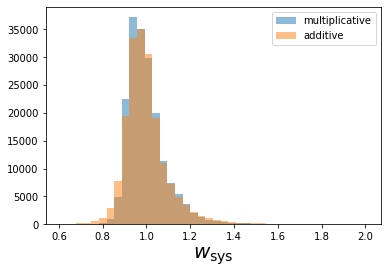

In [2]:
_, b, _ = plt.hist(1/wnn[mask], alpha=0.5, bins=40, label='multiplicative')
plt.hist(wnn2[mask], bins=b, alpha=0.5, label='additive')
plt.legend()
plt.xlabel(r'$w_{\rm sys}$', fontsize=20)

apply the weights on the galaxy count map, compute density contrast $\delta$, $C_{\ell}$

In [3]:
ngal1 = ngal / wnn # multiplicative
ngal2 = ngal * wnn2 # additive

# compute the density contrast
delta0 = overdensity(ngal, nran, mask)
delta1 = overdensity(ngal1, nran, mask)
delta2 = overdensity(ngal2, nran, mask)

# compute mean density vs ebv
nbar = MeanDensity(ngal, nran, mask, ebv)
nbar.run()
nbar1 = MeanDensity(ngal1, nran, mask, ebv)
nbar1.run()
nbar2 = MeanDensity(ngal2, nran, mask, ebv)
nbar2.run()

# compute angular C_ell
af = AnaFast()
cl0 = af(delta0, nran, mask)
cl1 = af(delta1, nran, mask)
cl2 = af(delta2, nran, mask)

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


left: Mean density vs EBV, right: angular power spectrum

[Text(0, 0.5, '$C_{\\ell}$'), Text(0.5, 0, '$\\ell$')]

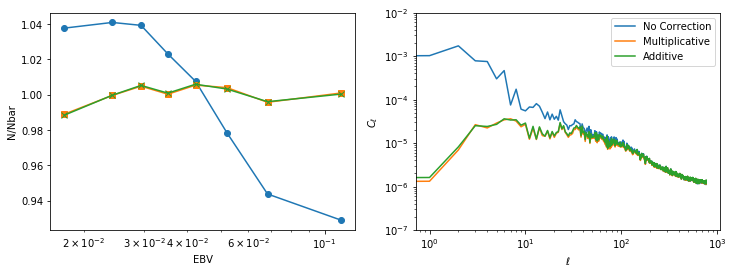

In [4]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

mk=['o', 's', 'x']
for i, nbar_i in enumerate([nbar, nbar1, nbar2]):
    ax[0].plot(nbar_i.output['bin_avg'], 
               nbar_i.output['nnbar'], 
               marker=mk[i])
    
ax[0].set(xlabel='EBV', ylabel='N/Nbar', xscale='log')

names = ['No Correction', 'Multiplicative', 'Additive']
for i, cli in enumerate([cl0, cl1, cl2]):
    ax[1].loglog(cli['l'], cli['cl'], label=names[i])
ax[1].set_ylim(1.0e-7, 1.0e-2)    
ax[1].legend()
ax[1].set(ylabel=r'$C_{\ell}$', xlabel=r'$\ell$')

ratio of the Cls

(0.8, 1.2)

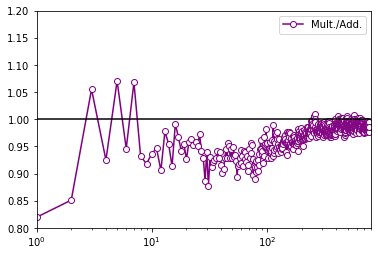

In [5]:
plt.plot(cl1['cl']/cl2['cl'], label='Mult./Add.', 
         marker='o', mfc='w', color='purple')
plt.legend()
plt.xlim(xmin=1)
plt.xscale('log')
plt.axhline(1, c='k')
plt.ylim(0.8, 1.2)